# Feature Extraction Power of CNNs: ImageNet Pretraining and MNIST Transfer Learning

Convolutional Neural Networks (CNNs) pretrained on large-scale datasets like ImageNet learn rich, general-purpose feature representations. These features capture edges, textures, shapes, and higher-level patterns, making them powerful for transfer learning to new tasks with limited data, such as MNIST digit classification.

**Before Transfer Learning:**
- The pretrained CNN extracts features that are generic and not specific to digits, but still capture useful visual patterns.

**After Transfer Learning (Fine-tuning on MNIST):**
- The CNN adapts its features to become more specialized for digit recognition, improving class separability in the feature space.

## Visualization Plan
1. Extract high-dimensional feature vectors from both the pretrained and fine-tuned CNNs.
2. Use three dimensionality reduction techniques (PCA, t-SNE, UMAP) to project these features onto a 2D plane.
3. Plot and compare the feature distributions to illustrate the effect of transfer learning.


In [ ]:
# Necessary tools
!pip install torch torchvision umap-learn --quiet

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch import nn

# Load pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()

# Prepare MNIST dataset (resize to 224x224, 3 channels to match ResNet input)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=256, shuffle=False)

# Avg pool layer er datagula nibo, bcz porer gula feature thake na, class probability hye jay
features = []
def hook(module, input, output):
    features.append(output.detach().cpu())

handle = resnet18.avgpool.register_forward_hook(hook)


/home/cse/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cse/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/cse/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.67MB/s]



Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:13<00:00, 726kB/s] 



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 50.2kB/s]



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:07<00:00, 220kB/s] 



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.53MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Extract features from pretrained ResNet18 on MNIST test data
import numpy as np

features.clear()
labels = []

with torch.no_grad():
    for images, targets in test_loader:
        _ = resnet18(images)
        labels.extend(targets.numpy())

# flaten krte hbe
pretrained_features = torch.cat(features, dim=0).squeeze().numpy()
labels = np.array(labels)
print('Pretrained features shape:', pretrained_features.shape)
print('Labels shape:', labels.shape)

Pretrained features shape: (10000, 512)
Labels shape: (10000,)


In [ ]:
import copy

# Mnist training data 
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)

# Replace the final layer for 10 MNIST classes
resnet18_ft = copy.deepcopy(resnet18)
resnet18_ft.fc = nn.Linear(resnet18_ft.fc.in_features, 10)

# Simple training loop (1 epoch for demonstration; )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_ft = resnet18_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_ft.parameters(), lr=1e-3)

resnet18_ft.train()
for images, targets in train_loader:
    images, targets = images.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = resnet18_ft(images)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

# Extract features from fine-tuned model on MNIST test data
features_ft = []
def hook_ft(module, input, output):
    features_ft.append(output.detach().cpu())
handle_ft = resnet18_ft.avgpool.register_forward_hook(hook_ft)

resnet18_ft.eval()
features_ft.clear()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        _ = resnet18_ft(images)

finetuned_features = torch.cat(features_ft, dim=0).squeeze().numpy()
print('Fine-tuned features shape:', finetuned_features.shape)

handle.remove()
handle_ft.remove()

Fine-tuned features shape: (10000, 512)


/home/cse/miniforge3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cse/miniforge3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/cse/miniforge3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cse/miniforge3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


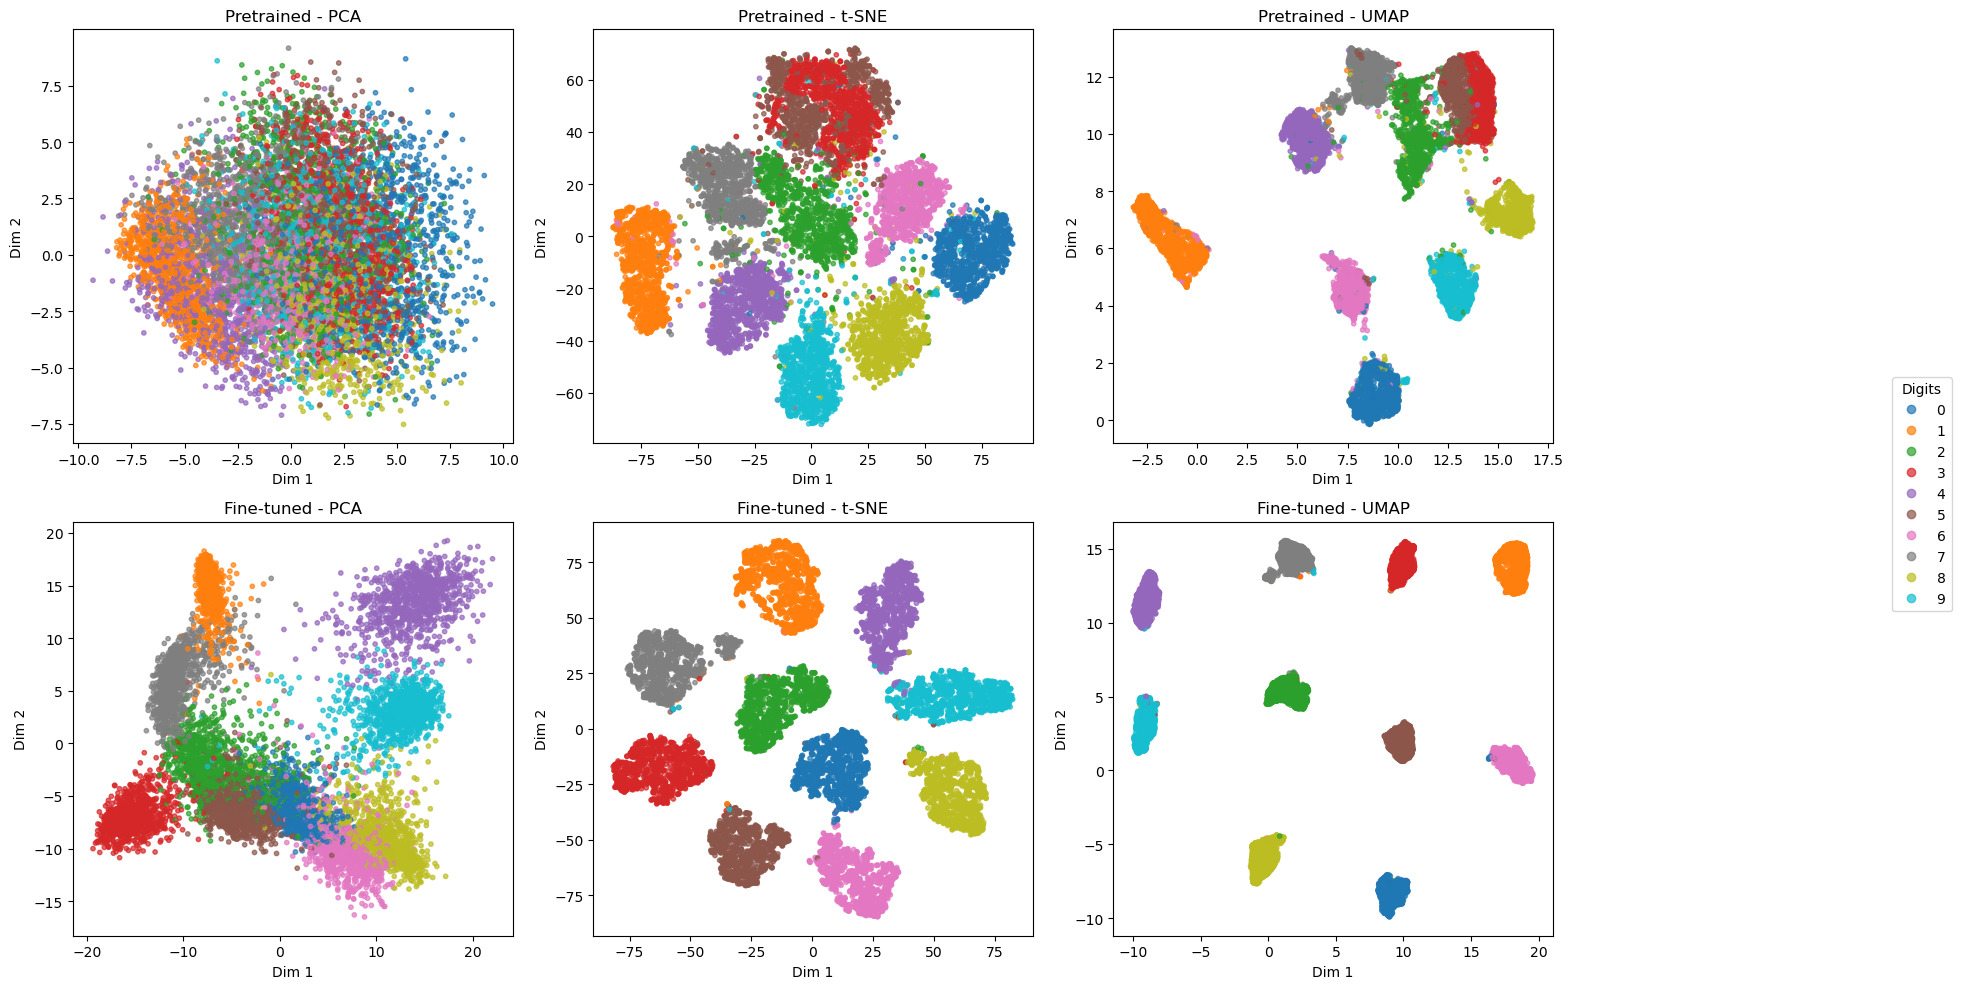

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# PCA
pca = PCA(n_components=2)
pretrained_pca = pca.fit_transform(pretrained_features)
finetuned_pca = pca.fit_transform(finetuned_features)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca')
pretrained_tsne = tsne.fit_transform(pretrained_features)
finetuned_tsne = tsne.fit_transform(finetuned_features)

# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
pretrained_umap = umap_reducer.fit_transform(pretrained_features)
finetuned_umap = umap_reducer.fit_transform(finetuned_features)

# Subplot all projections for quick glance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
projections = [
    (pretrained_pca, 'Pretrained - PCA'),
    (pretrained_tsne, 'Pretrained - t-SNE'),
    (pretrained_umap, 'Pretrained - UMAP'),
    (finetuned_pca, 'Fine-tuned - PCA'),
    (finetuned_tsne, 'Fine-tuned - t-SNE'),
    (finetuned_umap, 'Fine-tuned - UMAP'),
]

for ax, (proj, title) in zip(axes.flat, projections):
    scatter = ax.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    ax.set_title(title)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

handles, legend_labels = scatter.legend_elements()
fig.legend(handles, legend_labels, title="Digits", bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()